In [ ]:
!pip install --upgrade tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompat

In [33]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import os
import numpy as np
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import math
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

Getting the Dataset from google drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train_dir = r"/content/drive/MyDrive/Brain Tumor/Training"
test_dir = r"/content/drive/MyDrive/Brain Tumor/Testing"

**Pre Processing**

Check the size of images and dimensions

In [9]:
# Check for Train data
dataset_dir = train_dir

# Function to get the dimensions of images
def check_image_sizes(directory):
    sizes = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                filepath = os.path.join(subdir, file)
                with Image.open(filepath) as img:
                    sizes.append(img.size)  # (width, height)
    return sizes

# Get original sizes of images in training data
image_sizes = check_image_sizes(train_dir)
print(f"Number of images checked in Train Data: {len(image_sizes)}")
print(f"Sample sizes: {image_sizes[:5]}")  # Show sizes of the first 5 images

# Check for Test data
dataset_dir = test_dir

# Function to get the dimensions of images
def check_image_sizes(directory):
    sizes = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                filepath = os.path.join(subdir, file)
                with Image.open(filepath) as img:
                    sizes.append(img.size)  # (width, height)
    return sizes

# Get original sizes of images in training data
image_sizes = check_image_sizes(test_dir)
print(f"Number of images checked in Test Data: {len(image_sizes)}")
print(f"Sample sizes: {image_sizes[:5]}")  # Show sizes of the first 5 images

Number of images checked in Train Data: 5742
Sample sizes: [(219, 234), (512, 512), (512, 512), (512, 512), (512, 512)]
Number of images checked in Test Data: 1328
Sample sizes: [(295, 394), (206, 249), (212, 237), (257, 307), (440, 278)]


In [10]:
# Check any corrupt images
image_dir = "/content/drive/MyDrive/Brain Tumor/Training"

valid_image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

# Function for image validation
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Vérifie si l'image est valide
        return True
    except (IOError, SyntaxError):
        return False

# List the non images
non_image_files = []

for root, dirs, files in os.walk(image_dir):
    for file in files:
        file_path = os.path.join(root, file)

        file_extension = os.path.splitext(file)[1].lower()
        if file_extension not in valid_image_extensions:
            non_image_files.append(file)
        else:

            if not is_valid_image(file_path):
                non_image_files.append(file)

if non_image_files:
    print("Non-image or corrupted files found in Train Data:")
    for non_image in non_image_files:
        print(non_image)
else:
    print("All files are valid images in Train Data.")


# Check any corrupt images in Test Data
image_dir = "/content/drive/MyDrive/Brain Tumor/Test"

valid_image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

# Function for image validation
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Vérifie si l'image est valide
        return True
    except (IOError, SyntaxError):
        return False

# List the non images
non_image_files = []

for root, dirs, files in os.walk(image_dir):
    for file in files:
        file_path = os.path.join(root, file)

        file_extension = os.path.splitext(file)[1].lower()
        if file_extension not in valid_image_extensions:
            non_image_files.append(file)
        else:

            if not is_valid_image(file_path):
                non_image_files.append(file)

if non_image_files:
    print("Non-image or corrupted files found in Test Data:")
    for non_image in non_image_files:
        print(non_image)
else:
    print("All files are valid images in Test Data.")

All files are valid images in Train Data.
All files are valid images in Test Data.


In [11]:
seed_value = 42

**First Iteration**

In [12]:
# Data preprocessing for grayscale images with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
)

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for the test set

# Grayscale image generators for training and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    color_mode='grayscale',  # Grayscale images
    seed=seed_value,
    #shuffle = True,
    class_mode='categorical'  # Use categorical mode for multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    color_mode='grayscale',  # Grayscale images
    seed=seed_value,
    class_mode='categorical'  # Use categorical mode for multi-class classification
)

Found 5742 images belonging to 4 classes.
Found 1328 images belonging to 4 classes.


Check the number of images in each class

In [ ]:
# Check the number of images in Train dataset

# Get the class names and corresponding class indices
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# Get the number of samples (images) in each class
class_sample_count = train_generator.samples

# Get the number of images in each class
image_counts_per_class = {class_label: 0 for class_label in class_labels}

# Iterate through the batches and count images for each class
for i in range(len(train_generator)):
    images, labels = train_generator[i]  # Fetch the batch
    batch_labels = np.argmax(labels, axis=1)  # Convert one-hot to class indices

    for label in batch_labels:
        class_label = class_labels[label]
        image_counts_per_class[class_label] += 1
print("Train Data")
# Display the image counts per class
for class_label, count in image_counts_per_class.items():
    print(f"Class {class_label}: {count} images")

Train Data
Class glioma: 1331 images
Class meningioma: 1349 images
Class notumor: 1615 images
Class pituitary: 1457 images


In [ ]:
# Check the number of images in Test dataset

# Get the class names and corresponding class indices
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())

# Get the number of samples (images) in each class
class_sample_count = test_generator.samples

# Get the number of images in each class
image_counts_per_class = {class_label: 0 for class_label in class_labels}

# Iterate through the batches and count images for each class
for i in range(len(test_generator)):
    images, labels = test_generator[i]  # Fetch the batch
    batch_labels = np.argmax(labels, axis=1)  # Convert one-hot to class indices

    for label in batch_labels:
        class_label = class_labels[label]
        image_counts_per_class[class_label] += 1
print("Test Data")
# Display the image counts per class
for class_label, count in image_counts_per_class.items():
    print(f"Class {class_label}: {count} images")

Test Data
Class glioma: 300 images
Class meningioma: 316 images
Class notumor: 410 images
Class pituitary: 300 images


Display sample images

Training Images:


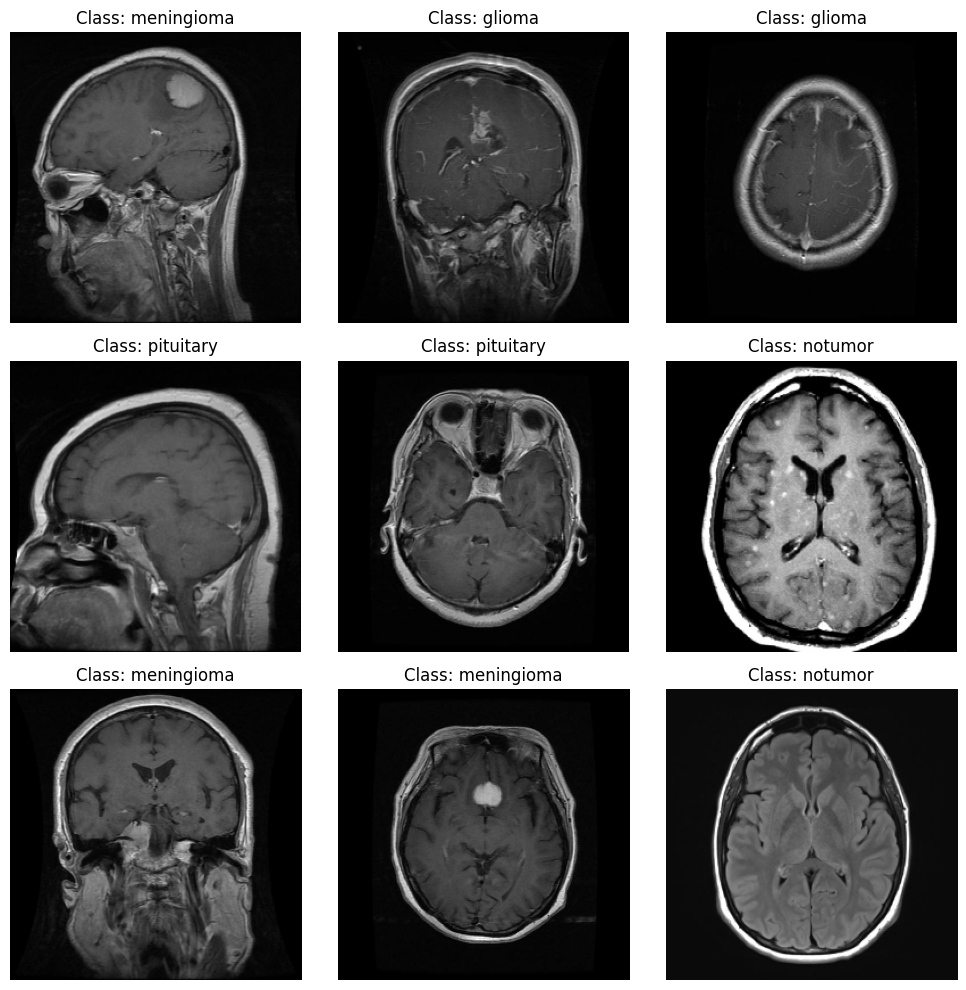

In [23]:
def display_images(images, labels, class_indices):
    class_names = {v: k for k, v in class_indices.items()}
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        image = images[i]

        if image.max() > 1:
            image = image / 255.0  # Normalization

        plt.imshow(image, cmap='gray')
        plt.title(f"Class: {class_names[labels[i].argmax()]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Obtenir un batch d'images et leurs labels
train_images, train_labels = next(train_generator)

# Afficher les images d'entraînement
print("Training Images:")
display_images(train_images, train_labels, train_generator.class_indices)

In [ ]:
#Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),  # Input size (256, 256, 1)
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # Output layer with 4 units for 4 classes
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      31,490,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,509,508 (120.20 MB)

 Trainable params: 31,509,508 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Pass to fit()
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=5,
                    validation_data=test_generator,
                    validation_steps=len(test_generator))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 767s 4s/step - accuracy: 0.6234 - loss: 1.0702 - val_accuracy: 0.8265 - val_loss: 0.4266
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


180/180 ━━━━━━━━━━━━━━━━━━━━ 774s 4s/step - accuracy: 0.9227 - loss: 0.2258 - val_accuracy: 0.9080 - val_loss: 0.2276
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 117us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 729s 4s/step - accuracy: 0.9652 - loss: 0.1109 - val_accuracy: 0.9367 - val_loss: 0.1657


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

42/42 - 47s - 1s/step - accuracy: 0.9367 - loss: 0.1657

Test accuracy: 0.9366515874862671


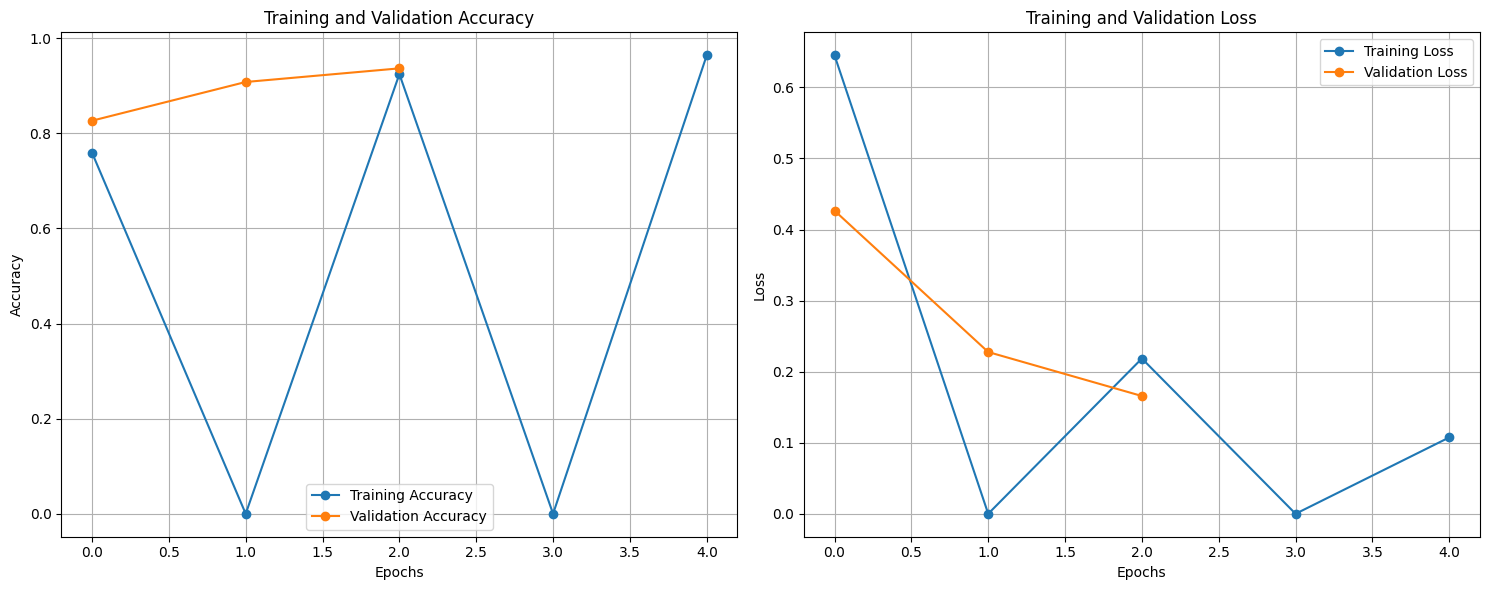

In [ ]:
import matplotlib.pyplot as plt

# Evaluate model performance: Accuracy and Loss Curves
def plot_accuracy_and_loss(history):
    plt.figure(figsize=(15, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history)

42/42 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step
Confusion Matrix:
[[ 72  69  89  70]
 [ 86  71  91  68]
 [ 84  85 145  96]
 [ 70  60  95  75]]


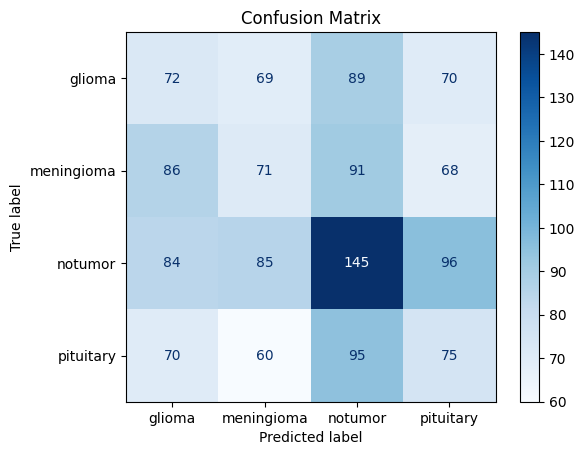

Classification Report:
              precision    recall  f1-score   support

      glioma       0.23      0.24      0.24       300
  meningioma       0.25      0.22      0.24       316
     notumor       0.35      0.35      0.35       410
   pituitary       0.24      0.25      0.25       300

    accuracy                           0.27      1326
   macro avg       0.27      0.27      0.27      1326
weighted avg       0.27      0.27      0.27      1326



In [ ]:
# Get the true labels and predictions for the test set
y_true = test_generator.classes  # True labels
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())

# Predict on the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Compute the Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the Confusion Matrix
print("Confusion Matrix:")
print(cm)

# Plot the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report for more details
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

**Second Iteraion**

Now, here I change the number of epochs to 10 and I remove steps_per_epoch and validation_steps from code.

In [ ]:
# Pass to fit()
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - accuracy: 0.9916 - loss: 0.0351 - val_accuracy: 0.9246 - val_loss: 0.2454
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 729s 4s/step - accuracy: 0.9943 - loss: 0.0292 - val_accuracy: 0.9442 - val_loss: 0.2429
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 781s 4s/step - accuracy: 0.9943 - loss: 0.0167 - val_accuracy: 0.9510 - val_loss: 0.1826
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 762s 4s/step - accuracy: 0.9990 - loss: 0.0049 - val_accuracy: 0.9578 - val_loss: 0.2201
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 747s 4s/step - accuracy: 1.0000 - loss: 8.8704e-04 - val_accuracy: 0.9555 - val_loss: 0.2356
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 737s 4s/step - accuracy: 1.0000 - loss: 3.3440e-04 - val_accuracy: 0.9540 - val_loss: 0.2484
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 736s 4s/step - accuracy: 1.0000 - loss: 2.5110e-04 - val_accuracy: 0.9570 - val_loss: 0.2588
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 765s 4s/step - accuracy: 1.0000 - loss: 1.523

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

42/42 - 43s - 1s/step - accuracy: 0.9555 - loss: 0.2798

Test accuracy: 0.9555052518844604


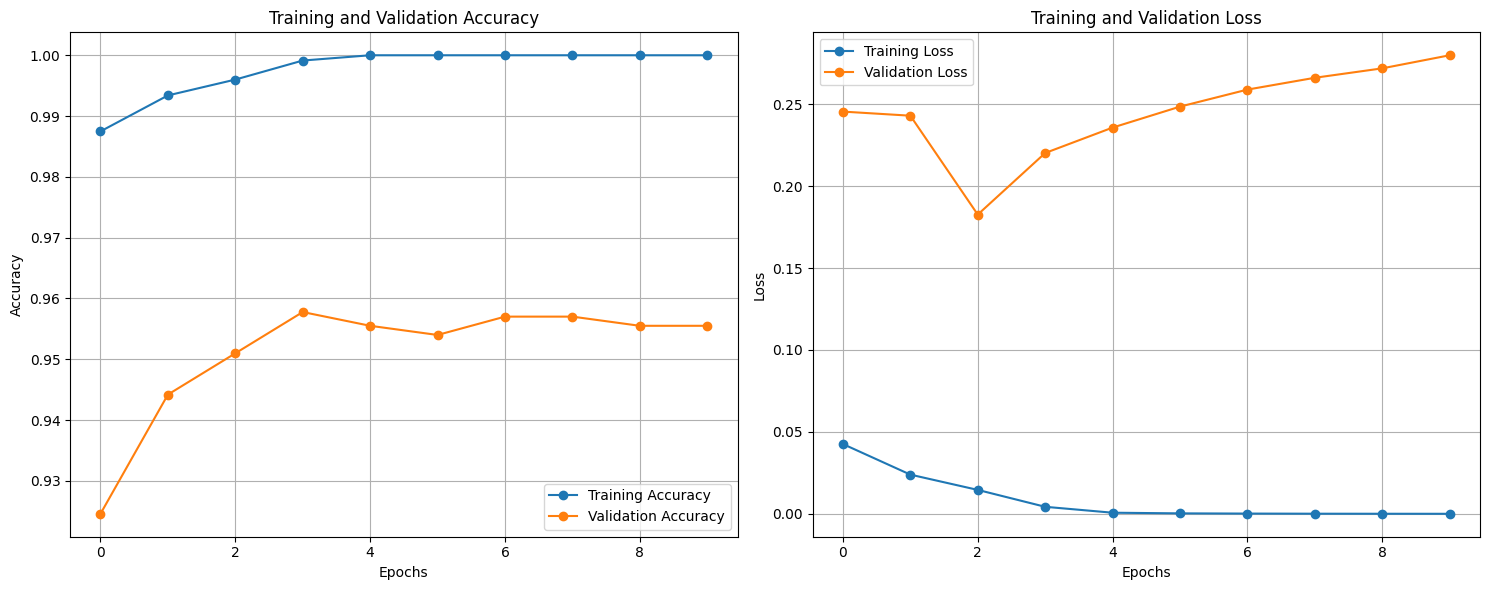

In [ ]:
import matplotlib.pyplot as plt

# Evaluate model performance: Accuracy and Loss Curves
def plot_accuracy_and_loss(history):
    plt.figure(figsize=(15, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history)

42/42 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step
Confusion Matrix:
[[ 55  73  94  78]
 [ 76  73  99  68]
 [ 86 100 132  92]
 [ 65  79  93  63]]


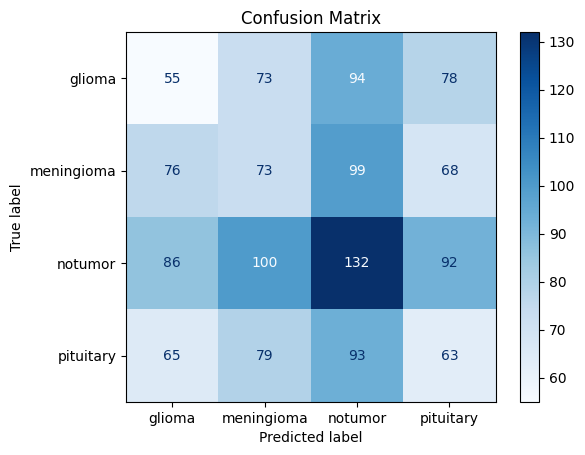

Classification Report:
              precision    recall  f1-score   support

      glioma       0.20      0.18      0.19       300
  meningioma       0.22      0.23      0.23       316
     notumor       0.32      0.32      0.32       410
   pituitary       0.21      0.21      0.21       300

    accuracy                           0.24      1326
   macro avg       0.24      0.24      0.24      1326
weighted avg       0.24      0.24      0.24      1326



In [ ]:
# Get the true labels and predictions for the test set
y_true = test_generator.classes  # True labels
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())

# Predict on the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Compute the Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the Confusion Matrix
print("Confusion Matrix:")
print(cm)

# Plot the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report for more details
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

**Third Iteration**

In [ ]:
# Data preprocessing for grayscale images with data augmentation
train_datagen1 = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1]
)

test_datagen1 = ImageDataGenerator(
    rescale=1./255  # Only rescale for the test set
)

# Grayscale image generators for training and testing
train_generator1 = train_datagen1.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='grayscale',  # Grayscale images
    seed=seed_value,
    shuffle=True,  # Shuffle for training
    class_mode='categorical'  # Use categorical mode for multi-class classification
)

test_generator1 = test_datagen1.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='grayscale',  # Grayscale images
    seed=seed_value,
    shuffle=False,  # No shuffling for testing/predictions
    class_mode='categorical'  # Use categorical mode for multi-class classification
)


Found 5752 images belonging to 4 classes.
Found 1326 images belonging to 4 classes.


In [ ]:
# Define the learning rate
learning_rate = 0.001

# Create the model
model2 = Sequential([
    Input(shape=(256, 256, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4, activation='softmax')
])

# Define the optimizer
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model2.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Try + hyperparameters
optimizer = Adam(learning_rate=0.001)
# Callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model2.fit(
    train_generator1,
    epochs=5,
    validation_data=test_generator1,
    callbacks=[early_stopping]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 856s 5s/step - accuracy: 0.5612 - loss: 1.4605 - val_accuracy: 0.8265 - val_loss: 0.4456
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 803s 4s/step - accuracy: 0.8734 - loss: 0.3339 - val_accuracy: 0.8861 - val_loss: 0.2770
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 790s 4s/step - accuracy: 0.9345 - loss: 0.1823 - val_accuracy: 0.9057 - val_loss: 0.2554
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 792s 4s/step - accuracy: 0.9624 - loss: 0.1141 - val_accuracy: 0.9321 - val_loss: 0.2049
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 797s 4s/step - accuracy: 0.9779 - loss: 0.0664 - val_accuracy: 0.9359 - val_loss: 0.1937


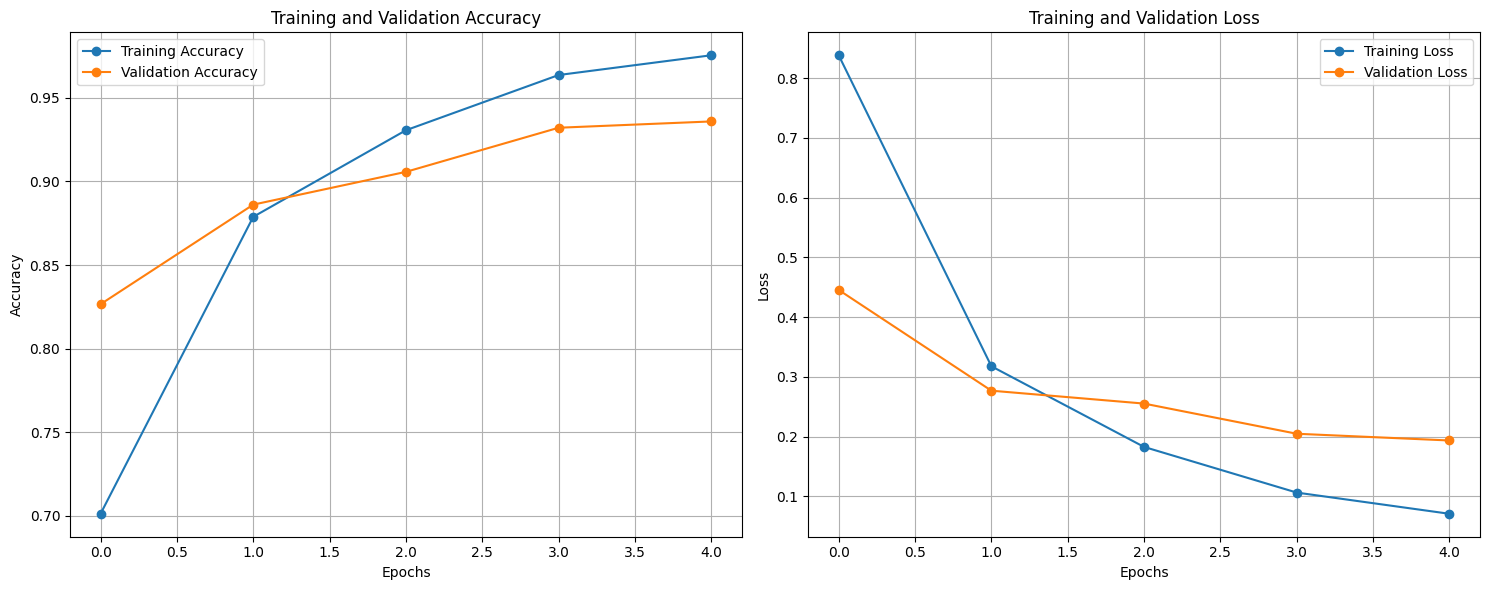

In [ ]:
# Evaluate model performance: Accuracy and Loss Curves
def plot_accuracy_and_loss(history):
    plt.figure(figsize=(15, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history)

In [ ]:
# Evaluate the model
score = model2.evaluate(test_generator1, verbose=0)
print(f"Test loss: {score[0]}, Test accuracy: {score[1]}")

Test loss: 0.193675696849823, Test accuracy: 0.9358974099159241


In [ ]:
model2.evaluate(test_generator1, batch_size=32)
model2.predict(test_generator1, batch_size=32)

42/42 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8811 - loss: 0.3183
42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step


array([[9.62561250e-01, 2.92044561e-02, 7.18492223e-03, 1.04936841e-03],
       [9.94621873e-01, 5.02480846e-03, 3.26561931e-05, 3.20647407e-04],
       [9.45625901e-01, 5.43593317e-02, 7.59049090e-06, 7.19156424e-06],
       ...,
       [1.51022803e-04, 3.99666984e-04, 1.31614693e-03, 9.98133242e-01],
       [1.13606555e-04, 1.51701597e-03, 1.02584869e-04, 9.98266816e-01],
       [1.13392140e-09, 7.50023057e-04, 5.85350936e-05, 9.99191463e-01]],
      dtype=float32)

42/42 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step


<Figure size 800x800 with 0 Axes>

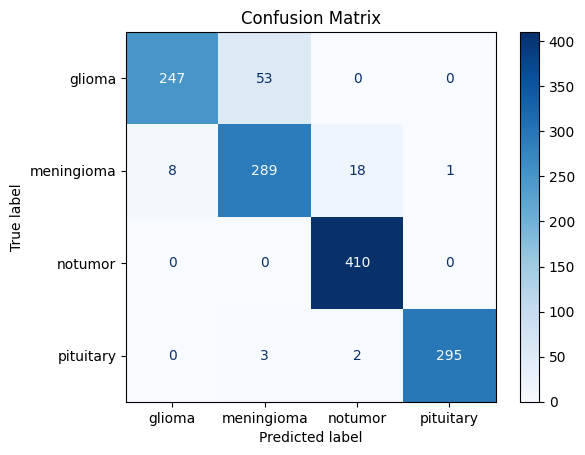

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.82      0.89       300
  meningioma       0.84      0.91      0.87       316
     notumor       0.95      1.00      0.98       410
   pituitary       1.00      0.98      0.99       300

    accuracy                           0.94      1326
   macro avg       0.94      0.93      0.93      1326
weighted avg       0.94      0.94      0.94      1326



In [ ]:
# Get the true labels and predictions for the test set
y_true = test_generator1.classes  # True labels
class_indices = test_generator1.class_indices
class_labels = list(class_indices.keys())  # Class names

# Predict on the test set
y_pred = model2.predict(test_generator1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Compute the Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Display the Confusion Matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report for more details
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


In [ ]:
print("Class Indices:", test_generator1.class_indices)
print("True Classes:", y_true[:10])  # First 10 true labels
print("Predicted Classes:", y_pred_classes[:10])  # First 10 predictions

Class Indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
True Classes: [0 0 0 0 0 0 0 0 0 0]
Predicted Classes: [0 0 0 1 0 1 0 0 0 0]


In [ ]:
for i in range(1):
    x_batch, y_batch = next(test_generator1)
    print("Batch shapes:", x_batch.shape, y_batch.shape)
    print("First batch true labels:", np.argmax(y_batch, axis=1))

Batch shapes: (32, 256, 256, 1) (32, 4)
First batch true labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
accuracy_manual = np.trace(conf_matrix) / np.sum(conf_matrix)
print("Confusion Matrix Accuracy:", accuracy_manual)

Confusion Matrix Accuracy: 0.9358974358974359


In [ ]:
loss, accuracy_eval = model2.evaluate(test_generator1, verbose=0)
print("Evaluate Function Accuracy:", accuracy_eval)

Evaluate Function Accuracy: 0.9479637742042542


In [ ]:
# Number of classes in the test generator
num_classes = test_generator1.num_classes
print(f"Number of classes in test_generator1: {num_classes}")

Number of classes in test_generator1: 4


**Four Iteration**

In [24]:
train_datagen2 = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill the gaps with nearest pixel
)


In [25]:
# Grayscale image generators for training and testing
train_generator2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    color_mode='grayscale',  # Grayscale images
    seed=42,
    shuffle = True,
    class_mode='categorical'  # Use categorical mode for multi-class classification
)

test_generator2 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    color_mode='grayscale',  # Grayscale images
    seed=seed_value,
    shuffle = False,
    class_mode='categorical'  # Use categorical mode for multi-class classification
)

Found 5742 images belonging to 4 classes.
Found 1328 images belonging to 4 classes.


I add one more Layer in this model with one dropout 0.5

In [26]:
from tensorflow.keras import Input

# Improved model architecture with more layers and filters
model3 = Sequential([
    Input(shape=(256, 256, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Increase dropout rate for regularization
    layers.Dense(4, activation='softmax')
])


In [43]:
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      58,982,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 177,232,910 (676.09 MB)

 Trainable params: 59,077,636 (225.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 118,155,274 (450.73 MB)

In [27]:
# Define the learning rate
learning_rate = 0.001

# Define the optimizer
optimizer = Adam(learning_rate=learning_rate)

model3.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

In [ ]:
# Enable eager execution
tf.config.run_functions_eagerly(True)

In [29]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model3.fit(
    train_generator2,
    epochs=15,
    validation_data=test_generator2,
    callbacks=[early_stopping]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 87s 403ms/step - accuracy: 0.3965 - loss: 1.4591 - precision: 0.6056 - recall: 0.1413 - val_accuracy: 0.6943 - val_loss: 0.8575 - val_precision: 0.7609 - val_recall: 0.5776
Epoch 2/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 117s 326ms/step - accuracy: 0.6539 - loss: 0.8172 - precision: 0.7435 - recall: 0.5342 - val_accuracy: 0.6973 - val_loss: 0.8387 - val_precision: 0.7678 - val_recall: 0.6024
Epoch 3/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 61s 330ms/step - accuracy: 0.7113 - loss: 0.7410 - precision: 0.7802 - recall: 0.6219 - val_accuracy: 0.7229 - val_loss: 0.7268 - val_precision: 0.7765 - val_recall: 0.6333
Epoch 4/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 63s 341ms/step - accuracy: 0.7287 - loss: 0.6935 - precision: 0.7900 - recall: 0.6395 - val_accuracy: 0.7289 - val_loss: 0.7161 - val_precision: 0.7568 - val_recall: 0.6935
Epoch 5/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 60s 324ms/step - accuracy: 0.7378 - loss: 0.6632 - precision: 0.7870 - recall: 0.6735 - val_accuracy: 0.6867 - val_los

In [30]:
# Evaluate the model
score = model3.evaluate(test_generator2, verbose=0)
print(f"Test loss: {score[0]}, Test accuracy: {score[1]}")

Test loss: 0.5027470588684082, Test accuracy: 0.8064758777618408


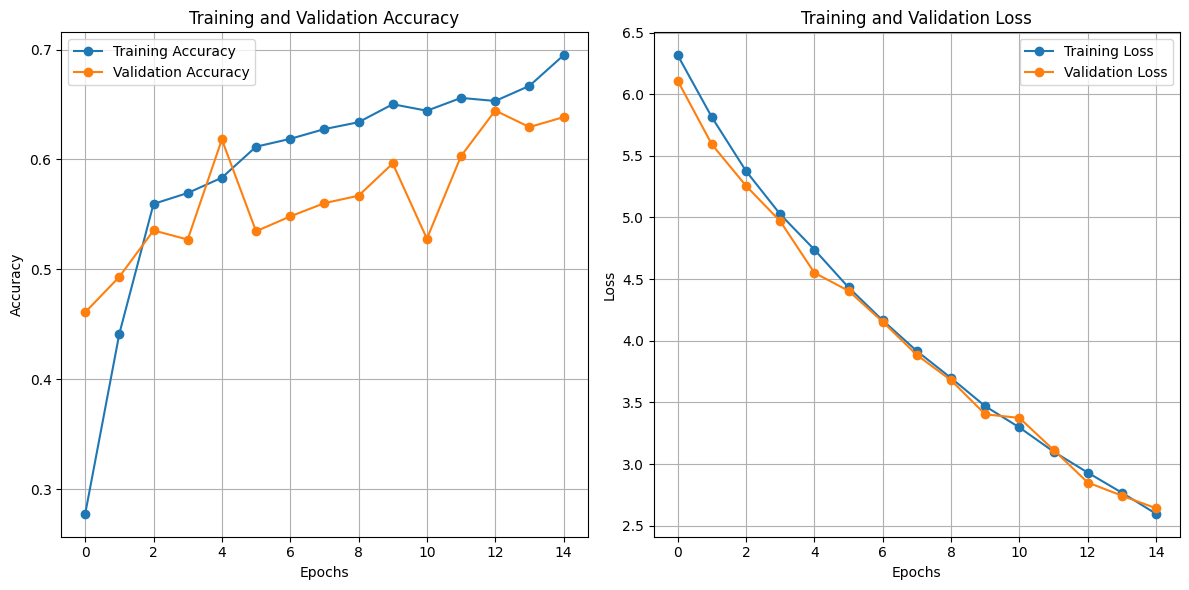

In [53]:
# Evaluate model performance: Accuracy and Loss Curves
def plot_accuracy_and_loss(history):
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history)

42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step
Confusion Matrix:
[[211  65   2  22]
 [ 24 172  83  37]
 [  2   0 406   4]
 [  5  11   2 282]]


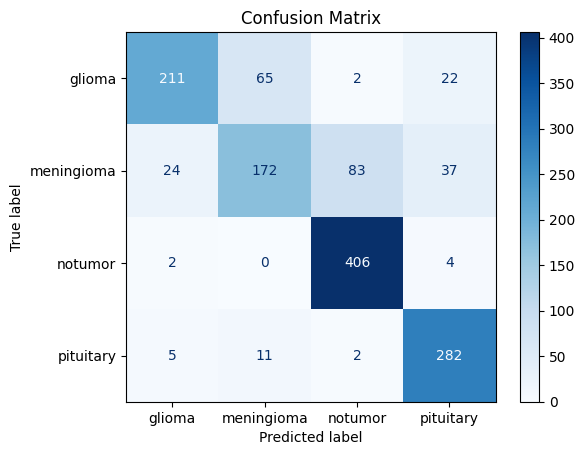

Classification Report:
              precision    recall  f1-score   support

      glioma       0.87      0.70      0.78       300
  meningioma       0.69      0.54      0.61       316
     notumor       0.82      0.99      0.90       412
   pituitary       0.82      0.94      0.87       300

    accuracy                           0.81      1328
   macro avg       0.80      0.79      0.79      1328
weighted avg       0.80      0.81      0.80      1328



In [34]:
# Get the true labels and predictions for the test set
y_true = test_generator2.classes  # True labels
class_indices = test_generator2.class_indices
class_labels = list(class_indices.keys())

# Predict on the test set
y_pred = model3.predict(test_generator2)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Compute the Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the Confusion Matrix
print("Confusion Matrix:")
print(cm)

# Plot the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report for more details
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

**Fifth Iteration**

I change batch size to 64

In [44]:
# Grayscale image generators for training and testing
train_generator4 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=64,
    color_mode='grayscale',  # Grayscale images
    seed=seed_value,
    shuffle = True,
    class_mode='categorical'  # Use categorical mode for multi-class classification
)

test_generator4 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=64,
    color_mode='grayscale',  # Grayscale images
    seed=seed_value,
    shuffle = False,
    class_mode='categorical'  # Use categorical mode for multi-class classification
)

Found 5742 images belonging to 4 classes.
Found 1328 images belonging to 4 classes.


In [45]:
model4 = Sequential()
model4.add(Conv2D(32,(3,3),activation= 'relu',input_shape=(256,256,1)))
model4.add(Conv2D(64,(3,3),activation='relu'))
model4.add(MaxPooling2D(2,2))
model4.add(Dropout(0.2))

model4.add(Conv2D(128,(3,3),activation='relu'))
model4.add(MaxPooling2D(2,2))
model4.add(Dropout(0.3))

model4.add(Conv2D(128,(3,3),activation='relu'))
model4.add(Conv2D(256,(3,3),activation='relu'))
model4.add(MaxPooling2D(2,2))
model4.add(Dropout(0.4))

model4.add(Flatten())

model4.add(Dense(512,activation = 'relu'))

model4.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model4.add(Dense(512,activation = 'relu'))
model4.add(Dropout(0.5))


model4.add(Dense(4,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [69]:
model4.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 252, 252, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 124, 124, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 60, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 58, 58, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 29, 29, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 29, 29, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 215296)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │     110,232,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,589,706 (849.11 MB)

 Trainable params: 111,294,852 (424.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 111,294,854 (424.56 MB)

Here I use SGD as optimizer

In [51]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

# Define the learning rate
learning_rate = 0.002

# Define the optimizer
optimizer = SGD(learning_rate=learning_rate, momentum=0.9)  # Added momentum for faster convergence

# Compile the model
model4.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)


In [52]:
history = model4.fit(
    train_generator4,
    epochs=15,
    validation_data=test_generator4,
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.2678 - loss: 6.4205 - val_accuracy: 0.4608 - val_loss: 6.1093
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 69s 727ms/step - accuracy: 0.3832 - loss: 5.9228 - val_accuracy: 0.4932 - val_loss: 5.5928
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 70s 726ms/step - accuracy: 0.5435 - loss: 5.4823 - val_accuracy: 0.5354 - val_loss: 5.2568
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 84s 739ms/step - accuracy: 0.5724 - loss: 5.1003 - val_accuracy: 0.5271 - val_loss: 4.9700
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 69s 707ms/step - accuracy: 0.5600 - loss: 4.8422 - val_accuracy: 0.6182 - val_loss: 4.5517
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 69s 719ms/step - accuracy: 0.6157 - loss: 4.4958 - val_accuracy: 0.5346 - val_loss: 4.4051
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 84s 741ms/step - accuracy: 0.6135 - loss: 4.2314 - val_accuracy: 0.5482 - val_loss: 4.1544
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 85s 775ms/step - accuracy: 0.6285 - loss: 3.9639 - val_accuracy: 0.5602 

In [54]:
# Evaluate the model
score = model4.evaluate(test_generator2, verbose=0)
print(f"Test loss: {score[0]}, Test accuracy: {score[1]}")

Test loss: 2.6417644023895264, Test accuracy: 0.6385542154312134


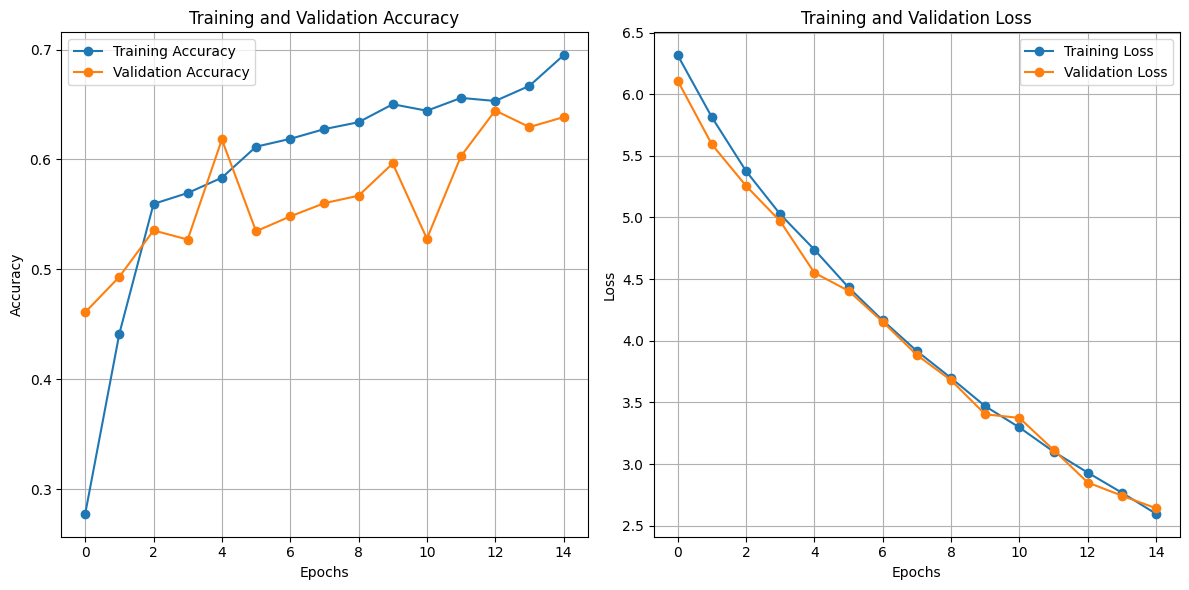

In [55]:
# Evaluate model performance: Accuracy and Loss Curves
def plot_accuracy_and_loss(history):
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history)

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step
Confusion Matrix:
[[259  31   0  10]
 [113 132  49  22]
 [ 31  93 236  52]
 [ 61  18   0 221]]


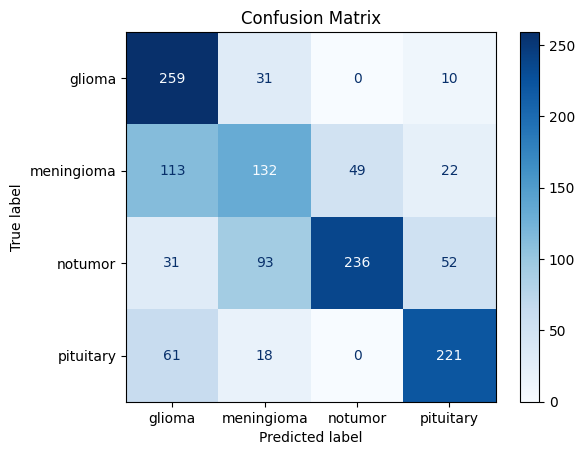

Classification Report:
              precision    recall  f1-score   support

      glioma       0.56      0.86      0.68       300
  meningioma       0.48      0.42      0.45       316
     notumor       0.83      0.57      0.68       412
   pituitary       0.72      0.74      0.73       300

    accuracy                           0.64      1328
   macro avg       0.65      0.65      0.63      1328
weighted avg       0.66      0.64      0.63      1328



In [78]:
# Get the true labels and predictions for the test set
y_true = test_generator4.classes  # True labels
class_indices = test_generator4.class_indices
class_labels = list(class_indices.keys())

# Predict on the test set
y_pred = model4.predict(test_generator4)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Compute the Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the Confusion Matrix
print("Confusion Matrix:")
print(cm)

# Plot the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report for more details
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

**Sixth Iteration**

For this time I change the kernal size to (5,5) and add padding

In [57]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.regularizers import l2

model5 = Sequential()

# First Convolutional Block
model5.add(Conv2D(32, (5, 5), activation='relu', input_shape=(256, 256, 1), padding='same'))
model5.add(MaxPooling2D(2, 2))
model5.add(Dropout(0.3))

# Second Convolutional Block
model5.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model5.add(MaxPooling2D(2, 2))
model5.add(Dropout(0.4))

# Third Convolutional Block with more filters
model5.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model5.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model5.add(MaxPooling2D(2, 2))
model5.add(Dropout(0.5))

# Fourth Convolutional Block with increased complexity
model5.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model5.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model5.add(MaxPooling2D(2, 2))
model5.add(Dropout(0.6))

# Flattening the 3D outputs to 1D for Dense layers
model5.add(Flatten())

# Fully connected layers with L2 regularization and Dropout for regularization
model5.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))
model5.add(Dropout(0.5))
model5.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model5.add(Dropout(0.5))

# Output layer with 4 classes (softmax activation)
model5.add(Dense(4, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:
model5.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 256, 256, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 128, 128, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1024)                │      67,109,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,386,574 (787.30 MB)

 Trainable params: 68,795,524 (262.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,591,050 (524.87 MB)

In [60]:
# Define the learning rate
learning_rate = 0.01

# Define the optimizer
optimizer = Adam(learning_rate=learning_rate)

model5.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

In [61]:
history = model5.fit(
    train_generator4,
    epochs=50,
    validation_data=test_generator4,
)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.2694 - loss: 161.2971 - precision_3: 0.2766 - recall_3: 0.0162 - val_accuracy: 0.3102 - val_loss: 27.8691 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 78s 691ms/step - accuracy: 0.2836 - loss: 19.3118 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.3102 - val_loss: 7.8415 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 78s 648ms/step - accuracy: 0.2763 - loss: 6.9167 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.3102 - val_loss: 5.2202 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 662ms/step - accuracy: 0.2801 - loss: 4.9489 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.3102 - val_loss: 4.2987 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 643ms/step - accuracy: 0

In [76]:
# Evaluate the model
score = model5.evaluate(test_generator4, verbose=0)
print(f"Test loss: {score[0]}, Test accuracy: {score[1]}")

Test loss: 1.4191319942474365, Test accuracy: 0.3102409541606903


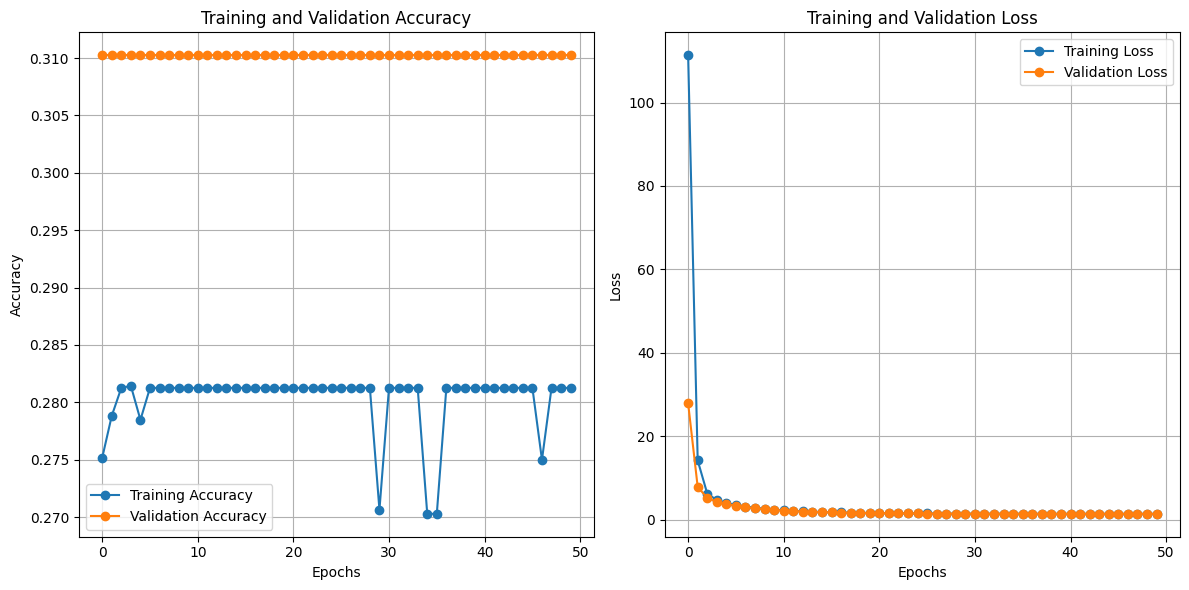

In [64]:
# Evaluate model performance: Accuracy and Loss Curves
def plot_accuracy_and_loss(history):
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history)

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step
Confusion Matrix:
[[  0   0 300   0]
 [  0   0 316   0]
 [  0   0 412   0]
 [  0   0 300   0]]


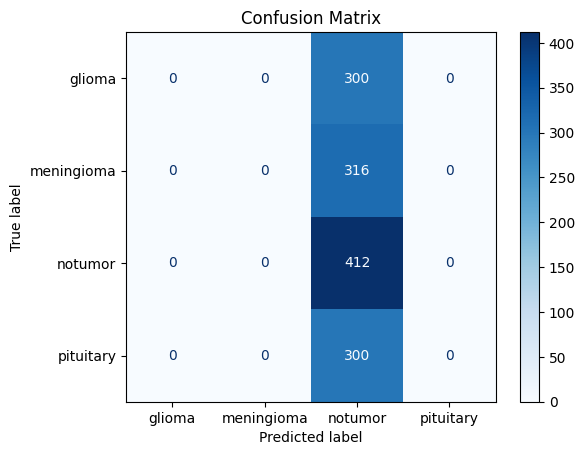

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       316
     notumor       0.31      1.00      0.47       412
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.31      1328
   macro avg       0.08      0.25      0.12      1328
weighted avg       0.10      0.31      0.15      1328



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [77]:
# Get the true labels and predictions for the test set
y_true = test_generator4.classes  # True labels
class_indices = test_generator4.class_indices
class_labels = list(class_indices.keys())

# Predict on the test set
y_pred = model5.predict(test_generator4)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Compute the Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the Confusion Matrix
print("Confusion Matrix:")
print(cm)

# Plot the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report for more details
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

**Seventh Iteration**

Here I am modifying the iteration3 code by adding one new layer in it with batch size =64 and 50 epochs.

In [67]:
# Define the learning rate
learning_rate = 0.001

# Create the model
model6 = Sequential([
    Input(shape=(256, 256, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4, activation='softmax')
])

# Define the optimizer
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model6.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [75]:
model6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,755,470 (338.58 MB)

 Trainable params: 29,585,156 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,170,314 (225.72 MB)

In [68]:
# Train the model
history = model6.fit(
    train_generator4,
    epochs=25,
    validation_data=test_generator4,
)

Epoch 1/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 89s 806ms/step - accuracy: 0.3954 - loss: 1.4462 - val_accuracy: 0.6047 - val_loss: 0.9543
Epoch 2/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 114s 615ms/step - accuracy: 0.6095 - loss: 0.9022 - val_accuracy: 0.6965 - val_loss: 0.7850
Epoch 3/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 632ms/step - accuracy: 0.7000 - loss: 0.7446 - val_accuracy: 0.6852 - val_loss: 0.8198
Epoch 4/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 638ms/step - accuracy: 0.7162 - loss: 0.7118 - val_accuracy: 0.7575 - val_loss: 0.6118
Epoch 5/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 59s 616ms/step - accuracy: 0.7336 - loss: 0.6572 - val_accuracy: 0.7372 - val_loss: 0.6888
Epoch 6/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 82s 613ms/step - accuracy: 0.7405 - loss: 0.6425 - val_accuracy: 0.7583 - val_loss: 0.6229
Epoch 7/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 61s 634ms/step - accuracy: 0.7589 - loss: 0.6243 - val_accuracy: 0.7372 - val_loss: 0.7113
Epoch 8/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 622ms/step - accuracy: 0.7704 - loss: 0.5821 - val_acc

In [72]:
# Evaluate the model
score = model6.evaluate(test_generator4, verbose=0)
print(f"Test loss: {score[0]}, Test accuracy: {score[1]}")

Test loss: 0.3743145167827606, Test accuracy: 0.8486445546150208


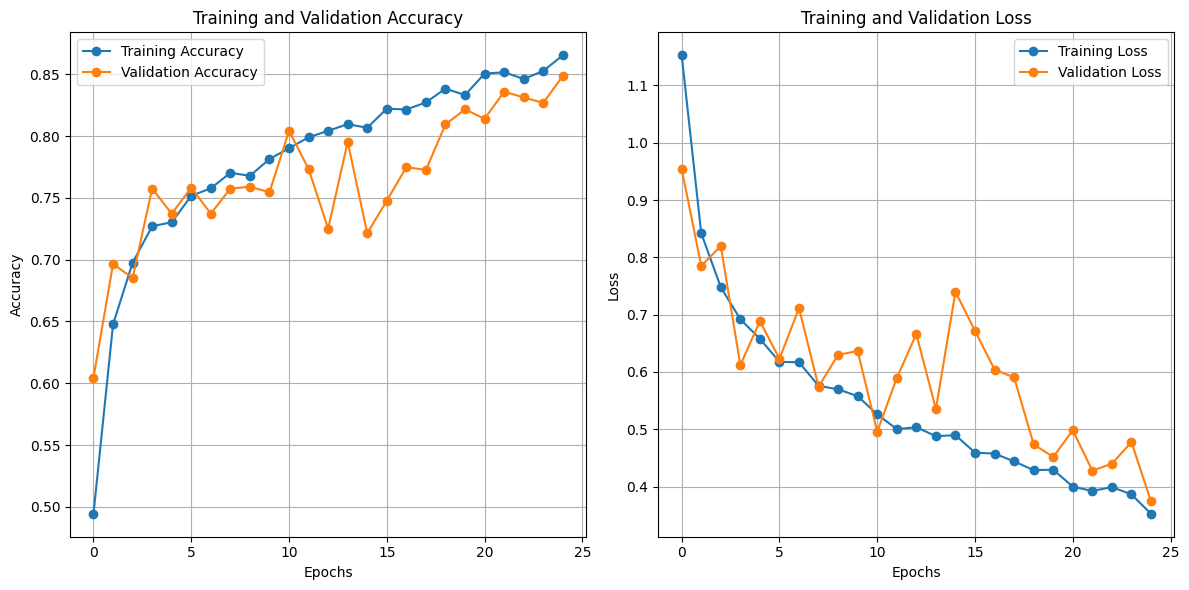

In [73]:
# Evaluate model performance: Accuracy and Loss Curves
def plot_accuracy_and_loss(history):
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history)

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step
Confusion Matrix:
[[239  47   0  14]
 [ 19 194  83  20]
 [  2   0 410   0]
 [  2  14   0 284]]


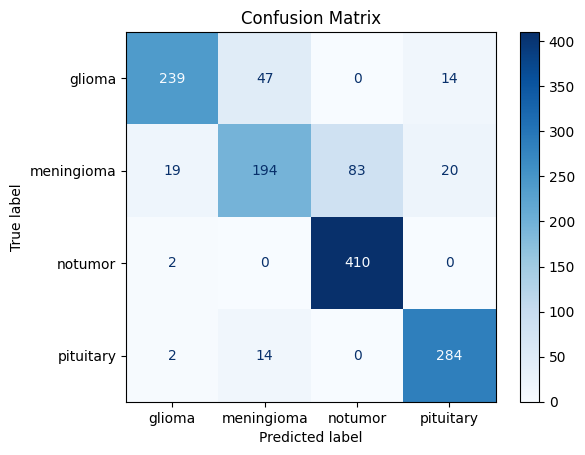

Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.80      0.85       300
  meningioma       0.76      0.61      0.68       316
     notumor       0.83      1.00      0.91       412
   pituitary       0.89      0.95      0.92       300

    accuracy                           0.85      1328
   macro avg       0.85      0.84      0.84      1328
weighted avg       0.85      0.85      0.84      1328



In [74]:
# Get the true labels and predictions for the test set
y_true = test_generator4.classes  # True labels
class_indices = test_generator4.class_indices
class_labels = list(class_indices.keys())

# Predict on the test set
y_pred = model6.predict(test_generator4)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Compute the Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the Confusion Matrix
print("Confusion Matrix:")
print(cm)

# Plot the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report for more details
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))